# Introduction to the project

In this project, we are going to take part to the ['Bike Sharing Demand' Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/overview).

We are going to use bike rental data from the Capital Bikeshare program in Washington, D.C.
The dataset contains hourly rental data spanning two years (2011 and 2012).

Our goal is to combine historical usage patterns with weather data in order to forecast bike rental demand.

The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

You'll find below the description of the fields:

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Introduction to the data and data cleaning

In [1]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

We don't have to delete any row as there is no missing value.

In [2]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

The `registered` and `casual` columns can be dropped as their sum represents the target column `count`. They're not present in the test dataset either.

In [3]:
train.drop(["casual", "registered"], axis = 1, inplace = True)

The following colums can be kept as they are as their current format are adequate to build a predictive model:
- dummy variables
    - `holiday`
    - `workingday`
- continuous variables (we might engineer new features based on those variables using binning in a further step)
    - `temp`
    - `atemp`
    - `humidity`
    - `windspeed`

# Feature engineering

## Handling categorical variables

The `season` and  `weather`columns are categorical columns. We need to encode them as dummy variables in order to use them our model.

In [4]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    return df

train = create_dummies(train, "season")
holdout = create_dummies(holdout, "season")
train = create_dummies(train, "weather")
holdout = create_dummies(holdout, "weather")

## Handling date column

Several information can be extracted from the `datetime` column:
- Day of the week
- Weekend vs weekday (already present in the dataset)
- Time of day
- Week of year number
- Month
- Year

For our project, we are going to extract the following information:
- Day of the week
- Time of day
- Month (we don't use week of year number for now as we want to limit the number of variables to use)
- Year

In [5]:
# Several operations to be applied on the `datetime`column in order to extract the desired information.

def transform_date(df):
    date_info = pd.DataFrame()
    date_info["datetime"] = pd.to_datetime(df["datetime"])
    
    # Extraction of the week of the day and creation of dummy variables.
    date_info["weekday"] = date_info["datetime"].dt.weekday
    date_info = create_dummies(date_info, "weekday")
    
    # Extraction of the time of the day and separation of these values into a categorical variable. 
    # Dummy variables are then created based on this categorical variable.
    date_info["time"] = date_info["datetime"].dt.strftime('%H').astype(int)
    date_info["time_category"] = pd.cut(date_info["time"], [-1,6,12,18,24], ["0-6", "6-12", "12-18", "18-24"])
    date_info = create_dummies(date_info, "time_category")
    
    # Extraction of the month and year and creation of dummy variables.
    date_info["month"] = date_info["datetime"].dt.month
    date_info = create_dummies(date_info, "month")
    date_info["year"] = date_info["datetime"].dt.year
    date_info = create_dummies(date_info, "year")
    
    columns_to_keep = date_info.columns.drop(["datetime", "weekday", "time", "time_category", "month", "year"])
    df = pd.concat([df, date_info[columns_to_keep]], axis = 1)
    return df

train = transform_date(train)
holdout = transform_date(holdout)

## Checking need to rescale numerical variables

In [7]:
scale_columns = ["temp", "atemp", "humidity", "windspeed"]
train[scale_columns].describe()

temp         atemp      humidity     windspeed
count  10886.00000  10886.000000  10886.000000  10886.000000
mean      20.23086     23.655084     61.886460     12.799395
std        7.79159      8.474601     19.245033      8.164537
min        0.82000      0.760000      0.000000      0.000000
25%       13.94000     16.665000     47.000000      7.001500
50%       20.50000     24.240000     62.000000     12.998000
75%       26.24000     31.060000     77.000000     16.997900
max       41.00000     45.455000    100.000000     56.996900

Even if there doesn't seem to be large discrepancies between minimums and maximums of the variables, we will rescale.

Indeed, as we will test algorithms that compute distance or assumes normality, we will scale our variables.

In [8]:
from sklearn.preprocessing import minmax_scale

for col in scale_columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


## Finding correlated features

When we start to add more features, we need to be aware of the concept of collinearity. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that your model will overfit - we may get great results on your test data set, but then the model performs worse on unseen data (like the holdout set).

This will happen whenever we create dummy columns, and is called the dummy variable trap. The easy solution is to choose one column to drop any time you make dummy columns.

In order to spot other features than dummy variables that may lead to colinearity, we can plot a correlation matrix.

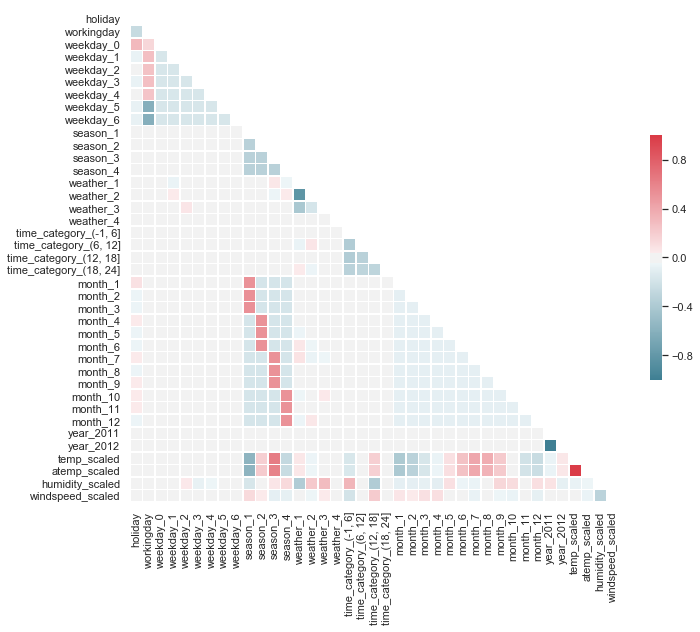

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_correlation_heatmap(df):
    corr = df.corr()
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize = (11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax= 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
columns = ['holiday', 'workingday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
           'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 
           'time_category_(-1, 6]', 'time_category_(6, 12]', 'time_category_(12, 18]', 'time_category_(18, 24]', 
           'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
           'month_11', 'month_12', 'year_2011', 'year_2012', 'temp_scaled','atemp_scaled', 'humidity_scaled', 
           'windspeed_scaled']

plot_correlation_heatmap(train[columns])

Logically, we will remove all `season_*` as this information is detained in the `month_*`columns.

Applying the same logic, we will drop the `workingday` column as it contains less information than all the `weekday_*` columns.

Moreover we will remove the `temp_scaled` column as it is logically highly correlated with the `atemp_scaled`column.

Finally, we will remove one column for each group of dummy columns:
- `weekday_0`
- `weather_1`
- `time_category_(6, 12]`
- `month_1`
- `year_1`

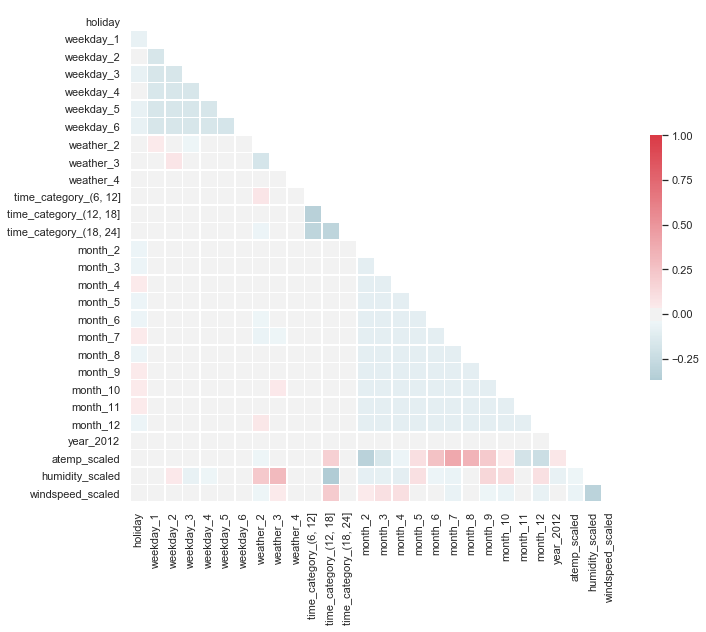

In [10]:
columns = ['holiday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
           'weather_2', 'weather_3', 'weather_4', 'time_category_(6, 12]', 'time_category_(12, 18]',
           'time_category_(18, 24]', 'month_2', 'month_3', 'month_4',
           'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
           'month_11', 'month_12', 'year_2012', 'atemp_scaled', 
           'humidity_scaled', 'windspeed_scaled']

plot_correlation_heatmap(train[columns])

We now have applied our first feature selection and feature engineering. We can further proceed by picking an error metric and elaborate our models.

# Finding the best algorithm

## Error metric

Before testing several algorithms to predict the total count of bikes rented per hour, we need to define our error metric.

The evaluation section for this competition on Kaggle tells us that submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

According to [this article](https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-2-regression-metrics-d4a1a9ba3d74) on Medium, "RMSLE penalizes an under-predicted estimate greater than an over-predicted estimate."

It is thus logical to use this error metric for our bike sharing demand. Indeed it's worse to have less available bikes than too many. While a missing bike might lead to an unsatified client, more bikes won't have any impact on the clients.

## How we will proceed

Here are the steps we are going to follow:

1. We will test 3 to 5 algorithms with all the features and we will very loosely optimize hyperparameters, just to make sure we don't assign extremely bad values to some hyperparameters. We will pick the best 2 to 3 of them.
2. After that, might will re-explore the data to find new patterns in the data and apply a secound round of feature engineering.
3. Thereafter, we will select the best-performing features. We will keep the same set of features for the remaining algorithms or select different sets.
4. We will tune our algorithms through an hyperparametrization procedure.
5. Finally, we will select our best algorithm.

## Testing several algorithms

### Linear regression

Let's start with the linear regression model using k-fold cross validation for more accurate error measurement.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train[columns], train['count'], test_size = 0.2, random_state = 0)
lr = LinearRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

In [12]:
predictions[predictions < 0]

array([ -47.87663558,  -25.86668019,  -49.32190753,  -27.68065035,
        -80.63049228,  -78.66156546,  -82.11646571,  -52.99735472,
        -21.35472655,  -54.91130827,  -18.85144453,   -2.70721224,
         -8.6043372 ,  -32.71323178,  -34.08192308, -168.74826643,
        -46.03448499,  -36.58413211,   -1.4456365 ,  -31.6672253 ,
         -6.85952559,  -32.74331447, -127.04284503,  -32.64337709,
        -36.58413211,  -15.05961098, -103.02648696,  -14.66011581,
       -134.77058161,   -6.11242895,  -26.73887075, -115.05789338,
         -4.69441199,  -55.69718778,   -3.1928177 ,  -36.43241209,
         -1.95903079,  -35.66514148,  -32.87478565,  -39.82863141,
        -82.52297379,  -25.02770277,  -98.79546727,  -32.06673668,
         -5.70455279,  -48.9031892 ,  -22.36132624,  -22.36132624,
        -68.15837817,  -84.24450756, -140.04458   ,  -58.6408999 ,
        -69.05380626,  -68.57780424,   -9.37300516,   -6.43154298,
        -93.79297796,  -21.91688832, -144.40868137, -163.44363

We notice that our model predicts negative values. Negative values don't represent a possible outcome as there can't be a negative number of bikes rented. Then solution is to not use linear regression (simple or multiple) since they do not solve the problem we have.

Moreover, if we would have decided to apply linear regression, the RMSLE error metric couldn't have been calculated as we can't apply a logarithmic function on a negative number.

Finally, as we have many feature variables, it is most likely that there is no linear relation between these variables and the target variable.

### K-Nearest Neighbors

Itâ€™s easy to implement and understand, but has a major drawback of becoming significantly slows as the size of that data in use grows.

KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then averages the labels in the case of regression.

We are first only going to slightly tune our model by optimizing the `n_neighbors` parameter.

We will further optimize the following ones if we chose to go further with the K-Nearest Neighbors algorithm:
- `weights`
- `algorithm`
- `p`

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()

hyperparameters_knn = {
    "n_neighbors": range(1,50,2)
}

grid = GridSearchCV(knn, param_grid=hyperparameters_knn, cv=10, scoring='neg_mean_squared_log_error')
grid.fit(train[columns], train["count"])

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 11}
-0.8802642848678158


In [14]:
grid.cv_results_

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([0.80643806, 0.74077692, 0.73607996, 0.69660287, 0.69520159,
        0.69870071, 0.70739782, 0.71879086, 0.77385921, 0.7158927 ,
        0.66361961, 0.65722754, 0.64543591, 0.71499689, 0.68022726,
        0.645631  , 0.68460915, 0.68221788, 0.71469426, 0.68571584,
        0.66373246, 0.69495769, 0.57117238, 0.60385525, 0.65080507]),
 'std_fit_time': array([0.42537649, 0.25788328, 0.35359762, 0.22596806, 0.36636225,
        0.35690359, 0.48987259, 0.31859498, 0.32037126, 0.10640198,
        0.1401711 , 0.24296174, 0.1313622 , 0.10956439, 0.07289225,
        0.09006894, 0.12130523, 0.11721181, 0.07714103, 0.1276161 ,
        0.11587769, 0.21268102, 0.2833188 , 0.25954556, 0.2795465 ]),
 'mean_score_time': array([0.49841614, 0.54599116, 0.76566417, 0.73358605, 0.95395503,
        0.87260354, 0.96244628, 0.93586872, 1.09986784, 1.05669227,
        1.19801741, 1.05429728, 0.98093212, 1.0482053 , 1.14284294,
        1.05040476, 1.09662564, 1.15244322, 1.2038146 , 1.12

By looking through the results, we notice that the 3 following values for the parameter `n_neighbors` provide the best results: 11, 9 and 13.

Nevertheless, scores of the different train/test splits (generated from K-Fold Cross Validation Using Scikit-Learn) vary widely. This large amount of variability between the RMSE values means that we're might use a poor model. That's why we'll have to tune our algorithm through an hyperparametrization procedure.

### Random forest regression

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.

Random forest might be a better fit to classify non-linearly separable data.

We are first going to use the Random Forest with default hyperparameters.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(random_state = 1)
rmsles_rf = cross_val_score(rf, train[columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
rmsle_rf = np.mean(rmsles_rf)

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

In [20]:
rmsles_rf

array([-1.7169303 , -0.86321688, -0.59527786, -0.71145999, -0.76346432,
       -1.48724317, -0.77226278, -0.63142086, -0.62143303, -0.64030678])

In [17]:
rmsle_rf

-0.8803015973036061

The Random Forest regressor algorithm seems to be on average slightly worse than the K-Nearest Neighbor one.

However, that algorithm faces the same variance among the scores of the different train/test splits.

### AdaBoost Regressor

We will use the AdaBoost algorithm for regression. What boosting does is that it makes multiple models in a sequential manner. Each newer model tries to successful predict what older models struggled with. For regression, the average of the models are used for the predictions. __It is often most common to use boosting with decision trees__ but this approach can be used with any machine learning algorithm that deals with supervised learning.

Boosting is associated with ensemble learning because several models are created that are averaged together. An assumption of boosting, is that combining several weak models can make one really strong and accurate model.

AdaBoost regressor might also be a better fit to classify non-linearly separable data.

We are first going to use a baseline regression tree model so we'll be able to compare it to the performance of our model that utilizes adaBoost. In order to make this model we need to Initiate a Kfold cross-validation. Next we will create a for loop so that we can create several trees that vary based on their depth. By depth, it is meant how far the tree can go to purify the regression. More depth often leads to a higher likelihood of overfitting.

In [18]:
from sklearn.tree import DecisionTreeRegressor

for depth in range(1,10):
    tree_regressor = DecisionTreeRegressor(max_depth=depth, random_state=1)
    rmsles_tr = cross_val_score(tree_regressor, train[columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
    rmsle_tr = np.mean(rmsles_tr)
    print(depth, rmsle_tr)

1 -2.12318740132308
2 -1.718882950647476
3 -0.9254810112941744
4 -0.9058778975442499
5 -0.8501004838944615
6 -0.8324732168781172
7 -0.8168274769560269
8 -0.8169450947050679
9 -0.8257292740772628


It looks like a tree with a depth of 7 had the lowest error (even lower than the Random Forest and the K-Nearest Neighbors with no hyperparametrization).

Let's now now move to the AdaBoost algorithm.

In [19]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7), random_state=1)
rmsles_ada = cross_val_score(ada, train[columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
rmsle_ada = np.mean(rmsles_ada)
rmsle_ada

-1.0872341768114904

In [23]:
rmsles_ada

array([-2.11282644, -1.17644935, -0.73005249, -0.78481255, -0.80002095,
       -1.91114227, -1.01775102, -0.73868447, -0.82826671, -0.7723355 ])

The average score is lower than the one achieved with a basic decision tree. 

However, it is likely that we might reach a better score with hyperparameter tuning. We'll do that in a second phase.

Note that the RMSLE scores vary again widely.  

# Engineering new features

Due to the high computing time for all algorithms and the already developed feature engineering done in the first phase, we won't re-explore the data to find new patterns.

# Selecting the best-performing features

## Recursive Feature Elimination applied on Random Forest

As K-Nearest Features algorithm does not provide logic to do feature selection, we can't use sklearn's implementation to achieve such goal, unless we define our own measure of feature importance for KNN.

We will then be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation with the Random Forest algorithm.

In [37]:
from sklearn.feature_selection import RFECV

rf = RandomForestRegressor(random_state = 1)
selector = RFECV(rf, cv=10, scoring='neg_mean_squared_log_error' )
selector.fit(train[columns], train["count"])

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\remyt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

RFECV(cv=10,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_squared_log_error', step=1, verbose=0)

In [38]:
optimized_columns = train[columns].columns[selector.support_]
print(optimized_columns)
print(columns)

Index(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weather_2', 'weather_3', 'time_category_(6, 12]',
       'time_category_(12, 18]', 'time_category_(18, 24]', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'year_2012', 'atemp_scaled', 'humidity_scaled',
       'windspeed_scaled'],
      dtype='object')
['holiday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4', 'time_category_(6, 12]', 'time_category_(12, 18]', 'time_category_(18, 24]', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year_2012', 'atemp_scaled', 'humidity_scaled', 'windspeed_scaled']


`holiday`, `weather_4`, `month_2`, `month_3` and `month_7` have been excluded from the recursive feature elimination with cross-validation.

In [45]:
selector.grid_scores_.max()

-0.8506953549801386

We can see that the average RMSLE has slightly improved: from 0.88 to 0.85.

## Best-Performing Features applied on K-Nearest Neighbors

In [50]:
knn = KNeighborsRegressor()

# We will only check for the best n_neighbors (9, 11 and 13) we got from our previous analysis
hyperparameters_knn = {
    "n_neighbors": range(9,14,3)
}

grid = GridSearchCV(knn, param_grid=hyperparameters_knn, cv=10, scoring='neg_mean_squared_log_error')
grid.fit(train[optimized_columns], train["count"])

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 9}
-0.8841556326533996


The score is still very similar to the previous one with no feature selection. 

## Best-Performing Features applied on AdaBoost Regressor

In [51]:
for depth in range(1,10):
    tree_regressor = DecisionTreeRegressor(max_depth=depth, random_state=1)
    rmsles_tr = cross_val_score(tree_regressor, train[optimized_columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
    rmsle_tr = np.mean(rmsles_tr)
    print(depth, rmsle_tr)

1 -2.12318740132308
2 -1.718882950647476
3 -0.9254810112941744
4 -0.9058778975442499
5 -0.8499287956059487
6 -0.8367721958135821
7 -0.8061981988085438
8 -0.8053857775953022
9 -0.8080946374768871


It looks like a tree with a depth of 8 had the lowest error (again lower than the Random Forest and the K-Nearest Neighbors with no hyperparametrization).

In [59]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8), random_state=1)
rmsles_ada = cross_val_score(ada, train[optimized_columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
rmsle_ada = np.mean(rmsles_ada)
rmsle_ada

-1.0536870036130304

In [60]:
rmsles_ada

array([-1.94246309, -1.07980894, -0.75218052, -0.89442129, -0.75526934,
       -1.83301347, -0.9747128 , -0.76302429, -0.81780553, -0.72417076])

Note that the RMSLE scores vary again widely and that the average score is lower than the one achieved with a basic decision tree.

# Selecting and Tuning Different Algorithms

Now that we have selected the best features and had a first glance of their impact on the different algorithms, let's tune the latter.

We are going to apply grid search which is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

In [58]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["count"]

    # List of dictionaries, each containing a model name,
    # its estimators and a dict of hyperparameters
    models = [
        {
            "name": "KNeighborsRegressor",
            "estimator": KNeighborsRegressor(),
            "hyperparameters":
                {
                    "n_neighbors": range(9,14,3),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["mse", "mae"],
                    "max_depth": [2, 5, 10], 
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8], 
                    "min_samples_split": [2, 3, 5] 

                }
        },
        {
            "name": "AdaBoostRegressor",
            "estimator": AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8), random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [50, 100],
                     "learning_rate" : [0.01,0.05,0.1,0.3,1],
                     "loss" : ["linear", "square", "exponential"]                    
                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10,
                            scoring='neg_mean_squared_log_error')
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,optimized_columns)


rf = RandomForestRegressor(random_state = 1)
rmsles_rf = cross_val_score(rf, train[columns], train["count"], cv = 10, scoring = 'neg_mean_squared_log_error')
rmsle_rf = np.mean(rmsles_rf)

KNeighborsRegressor
-------------------
Best Score: -0.8576912209798535
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

RandomForestRegressor
---------------------
Best Score: -0.9659958798678898
Best Parameters: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4}

AdaBoostRegressor
-----------------
Best Score: -0.7700667266302482
Best Parameters: {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 50}



In [64]:
result[2]["best_model"]

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.01, loss='square', n_estimators=50,
         random_state=1)

# Conclusion

We can conclude that the AdaBoost Regressor provides the lowest error. We are going to apply this one on the `test` dataset and publish the results on Kaggle.

It seems however weird that the average score of the Random Forest Regressor is worse than the one obtained above. We'll have to offer a wider range of values for the hyperparameters and apply and other round grid search.

In [66]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_date = holdout["datetime"]
    submission_df = {"datetime": holdout_date,
                 "count": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,optimized_columns)

# Next steps

1. Secound round of grid search for the Random Forest algorithm
2. Let's try other supervised machine learning algorithms such as:
    - SVM
    - Gradient Boosting
    - Neural Networks